# PART 1

In [1]:
import pandas as pd
import os
import requests
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

## (1): Download Twitter data

In [180]:
df = pd.read_csv("https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/data_twitter/H115_tw.csv")
twitter_names = list(df.tw_name)
dict_name_party = dict(zip(df.tw_name, df.Party))

## (2): Build the network of retweets. 

In [3]:
def get_tweets(account_name):
    base_url = "https://raw.githubusercontent.com/thomasnilsson/02805-dataset/master/tweets/"
    url = base_url + account_name
    req = requests.get(url)
    return req.text

In [4]:
def get_retweet_counts():
    retweets = dict()
    rt_pattern = r'RT @(\w+)'
    for tn in twitter_names:
        ts = get_tweets(tn)
        handles = re.findall(rt_pattern, ts)
        handles = [h for h in handles if h in twitter_names]
        retweets[tn] = {h: handles.count(h) for h in handles}
    return retweets

In [5]:
file = open("retweets.obj",'rb')
retweets = pickle.load(file)
file.close()

In [181]:
# A politcian class for storing data in a neat way.
class Politician:
    def __init__(self, name, party):
        self.TwitterName = name
        self.Party = party
    
    def to_string(self):
        return "TwitterName: %s, Party: %s" % (self.TwitterName, self.Party)
    
    def __hash__(self):
        return hash(self.TwitterName)
    
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.TwitterName == other.TwitterName
               )

## (3): Visualize the network of retweets and investigate differences between the parties.

In [183]:
# Converts degree dictionary to numpy array
def degree_array(G, direction="none"):
    if direction == "in":
        return dict_to_values_array(G.in_degree())
    elif direction == "out":
        return dict_to_values_array(G.out_degree())
    else:
        return dict_to_values_array(G.degree())
    
def dict_to_values_array(D):
    return np.array(list(D.values()))

In [184]:
UG = DG.to_undirected()
politicians = UG.nodes()
degrees = 2 * np.array(degree_array(UG))
color_map = []
for p in politicians:
    if p.Party == "Republican": 
        color_map.append("red")
    elif p.Party == "Democratic": 
        color_map.append("blue")
    else: 
        color_map.append("black")

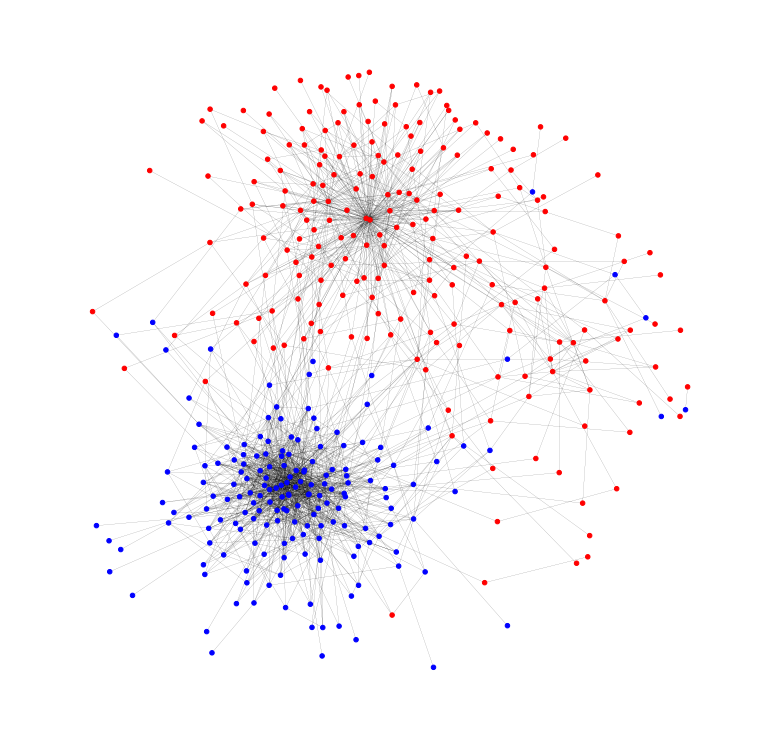

In [185]:
plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=20, width=0.1)
plt.show()

### Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). 
* Do you observe any difference? How do you explain them?

In [11]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/suneman/socialgraphs2018/master/files/blogosphere.jpg')

* Comment: It is clearly the case that just like the WikiPages, the retweets are also often kept within the party

### Now set the nodes' size proportional to their betweenness centrality. 
* What do you observe?
    * Betweenness is a measure of how often a node acts as a bridge between the shortest path between other nodes in the graph. 
    * Concretely it will represent how "diverse" a politicians retweets are, i.e. if the more people they retweet, the higher the betweenness centrality.
    * Answer: The republicans have a few very central nodes, whereas the centrality is more evenly distributed amongst the democratic nodes. 

In [186]:
B = nx.betweenness_centrality(DG)
B_values = np.array([B[pol] for pol in B])
sizes = 5000 * B_values # factor found through trial and error

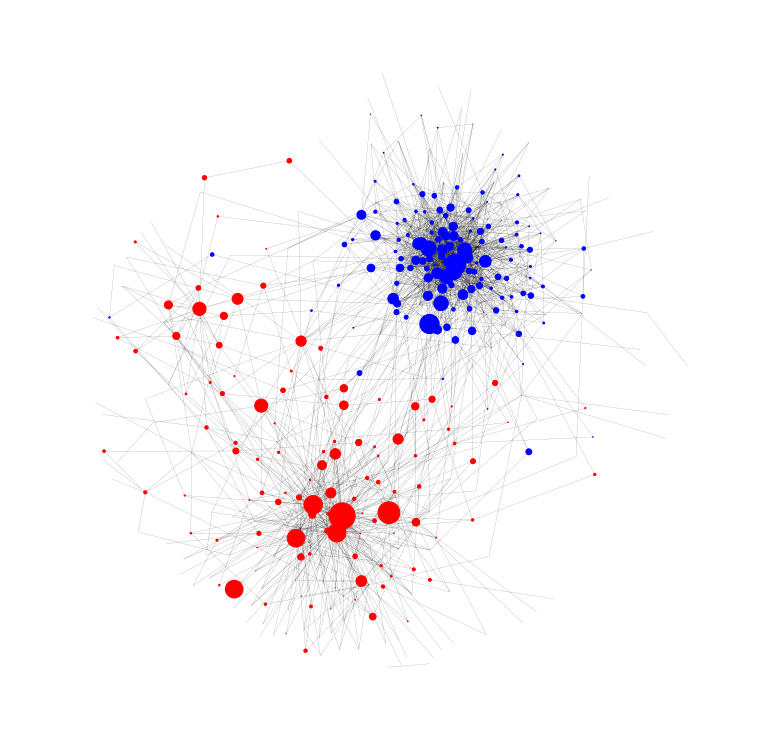

In [187]:
plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1)
plt.show()

### Repeat the point above using eigenvector centrality instead. 
* Is there any difference? Can you explain why?
    * The eigenvector centrality represents the "page rank" which in this case can be seen as the credibility, or how "cited/retweeted" a politician is, since incoming links represent retweets, in the directed graph.
    * The reason *why* this is the case, is explained by the fact that the two centrality measures represent different concepts, which have been discussed previously.
    * The conclusion is that the repubican party seems to have a little bit of a skewed distribution when it comes to how many different politicians they retweet, and even more skewed when it comes to which other house members they each retweet.
        * There seems to be a few (5-6) republican politicians who get retweeted a lot, and the rest do not have their tweets retweeted. 
        * The democratic party is more evently distributed with regards to both centrality measures, i.e. they retweet  other house members much more evenly.
        * Questions to be asked:
            * Is a possible cause that republicans tend to be more old school, and as a consequence are not aas astive of Twitter, as the democraits?
            * It could be relevant to look at the average age of the two parties, since age likely plays into how active a person is on social media.
    

In [188]:
EV = nx.eigenvector_centrality_numpy(DG)
EV_values = np.array([EV[pol] for pol in EV])
sizes = 5000 * EV_values # factor found through trial and error

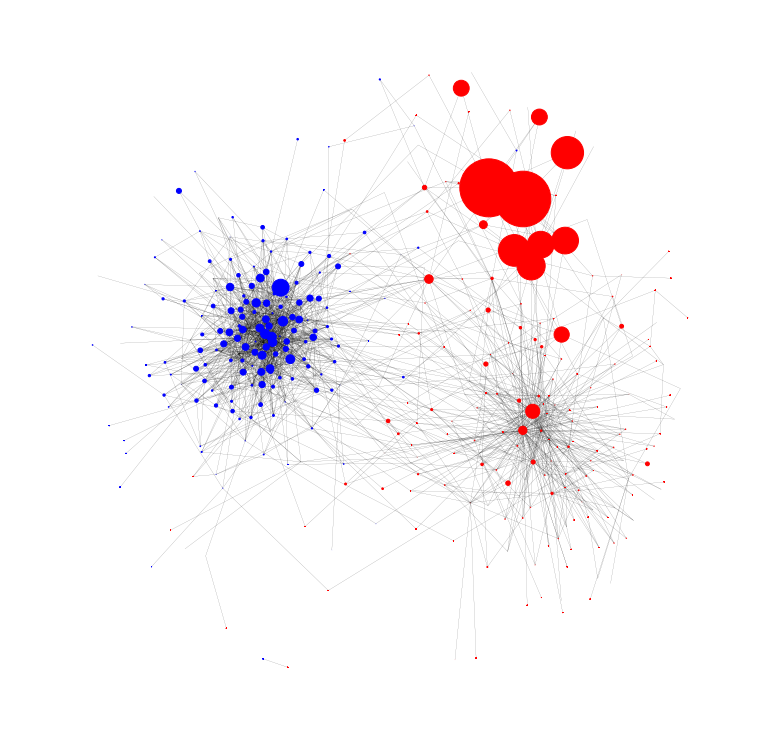

In [189]:
plt.figure(figsize=(10,10))
nx.draw(UG, node_color=color_map, node_size=sizes, width=0.1)
plt.show()

### Who are the three nodes with highest degree within each party? 
* And eigenvector centrality? 
* And betweenness centrality?

In [44]:
# Extract Nodes
nodes = DG.nodes()
repub_nodes = list(filter(lambda p: p.Party == "Republican", nodes))
demo_nodes = list(filter(lambda p: p.Party == "Democratic", nodes))

#### Degree centrality

In [45]:
D = nx.degree(DG)
repub_deg = {pol: D[pol] for pol in repub_nodes}
demo_deg = {pol: D[pol] for pol in demo_nodes}
repub_sortby_deg = sorted(repub_deg, key=repub_deg.get)
demo_sortby_deg = sorted(demo_deg, key=demo_deg.get)

print("Degree Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_deg[i].TwitterName)
    
print("Degree Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_deg[i].TwitterName)

Degree Centrality: Top 3 Republican Twitter Accounts
	- RepChrisSmith
	- michaelcburgess
	- USRepRodney
Degree Centrality: Top 3 Republican Twitter Accounts
	- RepChrisSmith
	- michaelcburgess
	- USRepRodney


* Comment: Louise Slaughter died this year in March, which may explain why so many politicians retweeted her. The reason she must have been retweeted is that is hard to retweet other people when you are dead...

#### Eigenvector centrality

In [52]:
repub_ev = {pol: EV[pol] for pol in repub_nodes}
demo_ev = {pol: EV[pol] for pol in demo_nodes}
repub_sortby_ev = sorted(repub_ev, key=repub_ev.get)
demo_sortby_ev = sorted(demo_ev, key=demo_ev.get)

print("Degree EV Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_ev[i].TwitterName)
    
print("Degree EV Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_ev[i].TwitterName)

Degree EV Centrality: Top 3 Republican Twitter Accounts
	- RepNewhouse
	- RepJohnKatko
	- RepSmucker
Degree EV Centrality: Top 3 Republican Twitter Accounts
	- RepLujanGrisham
	- RepPeteAguilar
	- USRepRickNolan


#### Betweenness Centrality

In [53]:
repub_b = {pol: B[pol] for pol in repub_nodes}
demo_b = {pol: B[pol] for pol in demo_nodes}
repub_sortby_b = sorted(repub_b, key=repub_b.get)
demo_sortby_b = sorted(demo_b, key=demo_b.get)

print("Degree Betweenness Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + repub_sortby_b[i].TwitterName)
    
print("Degree Betweenness Centrality: Top 3 Republican Twitter Accounts")
for i in range(3):
    print("\t- " + demo_sortby_b[i].TwitterName)

Degree Betweenness Centrality: Top 3 Republican Twitter Accounts
	- repdonyoung
	- RepHalRogers
	- RepChrisSmith
Degree Betweenness Centrality: Top 3 Republican Twitter Accounts
	- RepJohnConyers
	- RepThompson
	- RepCuellar


### Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes 
... (e.g. the sum of the weight on outgoing links). 
* Which party is more active in retweeting other members of the house?

In [172]:
def sum_retweets(retweets, name):
    rt = retweets[name]
    non_self_rt = {author: rt[author] for author in rt if author != name}
    return sum(non_self_rt.values())

In [173]:
repub_names = list(df[df.Party == "Republican"].tw_name)
demo_names = list(df[df.Party == "Democratic"].tw_name)
outgoing_repub = [sum_retweets(retweets, name) for name in repub_names]
outgoing_demo = [sum_retweets(retweets, name) for name in demo_names]

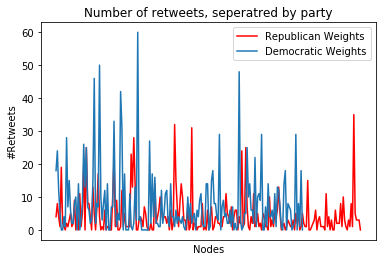

In [174]:
plt.plot(outgoing_repub, "red")
plt.plot(outgoing_demo)
plt.legend(["Republican Weights", "Democratic Weights"])
plt.title("Number of retweets, seperatred by party")
plt.xlabel("Nodes"); plt.ylabel("#Retweets"); plt.xticks([], []);
plt.show()

* Which party is more active in retweeting other members of the house?

In [145]:
avg_repub = sum(outgoing_repub) / len(outgoing_repub)
print("Avg. retweets per member (Republican): %.2f" % avg_repub)

Avg. retweets per member (Republican): 4.66


In [146]:
avg_demo = sum(outgoing_demo) / len(outgoing_demo)
print("Avg. retweets per member (Democratic): %.2f" % avg_demo)

Avg. retweets per member (Democratic): 9.04


* Conclusion: The democrats are on average twice as active when it comes to retweeting other members of the house of representatives.

### Find the 3 members of the republican party that have retweeted more often tweets from democratic members. 
* Repeat the measure for the democratic members. 
* Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [194]:
def sum_cross_retweets(retweets, mapping, name):
    party = mapping[name]
    rt = retweets[name]
    cross_rt = {
        author: rt[author] for author in rt 
        if author != name and mapping[author] != party # Check if name and party is different
    }
    return sum(cross_rt.values())

In [195]:
cross_repub = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in repub_names}
cross_demo = {name: sum_cross_retweets(retweets, dict_name_party, name) for name in demo_names}

In [200]:
cross_repub_sorted = sorted(cross_repub, key=cross_repub.get)
print("Cross-retweeting (Republican party), top 3")
for i in range(3):
    print("\t-" + cross_repub_sorted[i])
print()
print("Cross-retweeting (Democratic party), top 3")
cross_demo_sorted = sorted(cross_demo, key=cross_demo.get)
for i in range(3):
    print("\t-" + cross_demo_sorted[i])

Cross-retweeting (Republican party), top 3
	-RepChrisSmith
	-LamarSmithTX21
	-RepJohnDuncanJr

Cross-retweeting (Democratic party), top 3
	-RepJohnConyers
	-WhipHoyer
	-RepMarcyKaptur


#### Republicans
* https://en.wikipedia.org/wiki/Chris_Smith_(New_Jersey_politician)
